# Netflix Dataset — EDA Notebook

**Generated notebook**: loads the uploaded `Netflix Dataset.csv`, cleans data, performs exploratory data analysis, and creates visualizations aligned to the project objectives (Movies vs TV Shows over time, genre trends, country-wise contributions).

> Run the notebook cells sequentially. The dataset file `Netflix Dataset.csv` must remain in the same directory as the notebook or update the path in the first code cell.

In [2]:
# 1) Imports and load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Load dataset (adjust path if needed)
df = pd.read_csv(r'/content/Netflix Dataset.csv')

# Quick display
print('Dataset shape:', df.shape)
display(df.head())

Dataset shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## 2) Cleaning & preprocessing
- Parse release date
- Extract year
- Normalize column names
- Convert duration to numeric where possible
- Split genres (Type) into list

In [3]:
# 2) Cleaning & preprocessing
df = df.copy()
# Standardize column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Parse Release_Date to datetime (try multiple formats)
df['Release_Date_parsed'] = pd.to_datetime(df['Release_Date'], errors='coerce')

# Extract year
df['Year'] = df['Release_Date_parsed'].dt.year

# Clean Duration: try to extract numeric minutes or seasons
def parse_duration(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        # Minutes like '90 min' or '123 min'
        if 'min' in s:
            nums = ''.join([c for c in s if c.isdigit()])
            return int(nums) if nums else np.nan
        # Seasons like '1 Season' or '3 Seasons' -> keep seasons as negative to distinguish
        if 'Season' in s:
            nums = ''.join([c for c in s if c.isdigit()])
            return -int(nums) if nums else np.nan
        # Otherwise try to get digits
        nums = ''.join([c for c in s if c.isdigit()])
        return int(nums) if nums else np.nan
    except Exception:
        return np.nan

df['Duration_numeric'] = df['Duration'].apply(parse_duration)

# Split Type (genres) into lists
df['Genres'] = df['Type'].fillna('').apply(lambda s: [g.strip() for g in s.split(',')] if s else [])

# Category rename and basic check
df['Category'] = df['Category'].fillna(df['Type'])  # fallback if missing
df['Category'] = df['Category'].str.strip()

print('Parsed years:', df['Year'].dropna().astype(int).min(), 'to', df['Year'].dropna().astype(int).max())
display(df[['Title','Category','Year','Duration','Duration_numeric','Genres']].head())

Parsed years: 2008 to 2021


,Title,Category,Year,Duration,Duration_numeric,Genres
0,3%,TV Show,2020.0,4 Seasons,-4,"[International TV Shows, TV Dramas, TV Sci-Fi ..."
1,07:19,Movie,2016.0,93 min,93,"[Dramas, International Movies]"
2,23:59,Movie,2018.0,78 min,78,"[Horror Movies, International Movies]"
3,9,Movie,2017.0,80 min,80,"[Action & Adventure, Independent Movies, Sci-F..."
4,21,Movie,2020.0,123 min,123,[Dramas]


## 3) Movies vs TV Shows over time
Plot the count of Movies vs TV Shows by year.

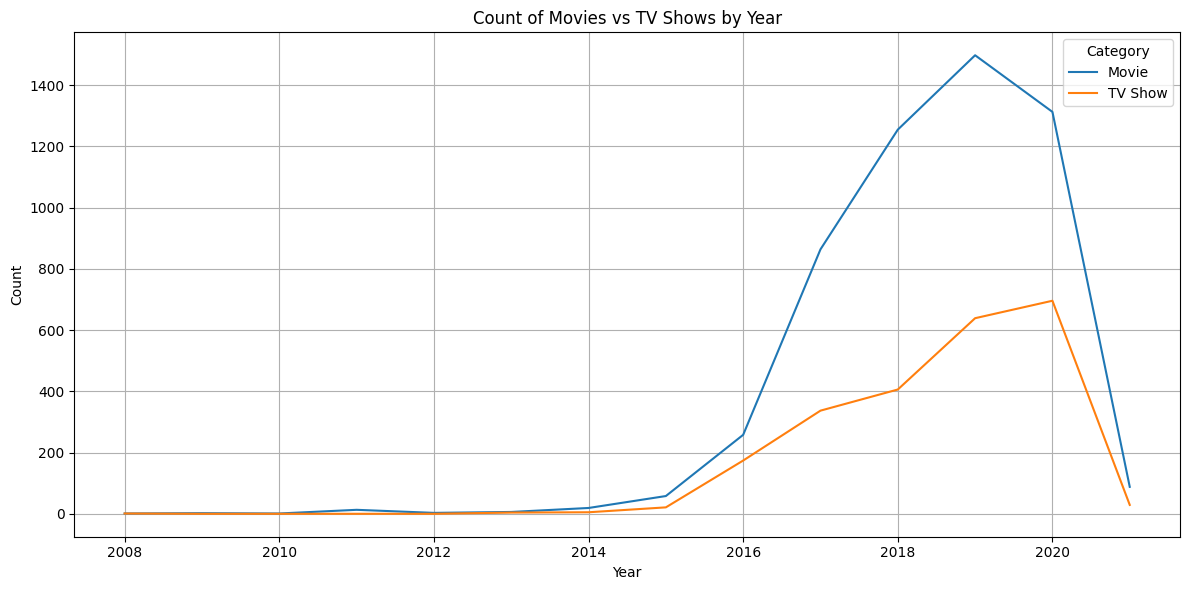

In [4]:
# 3) Movies vs TV Shows over time
count_by_year_type = df.groupby(['Year','Category']).size().unstack(fill_value=0).sort_index()

# Plot
plt.figure(figsize=(12,6))
count_by_year_type.plot(kind='line', ax=plt.gca())
plt.title('Count of Movies vs TV Shows by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4) Genres analysis
- Top genres overall
- Trend of top genres over time

Top 10 genres overall:


,count
Genres,
International Movies,2437
Dramas,2108
Comedies,1472
International TV Shows,1199
Documentaries,786
Action & Adventure,721
TV Dramas,704
Independent Movies,675
Children & Family Movies,532


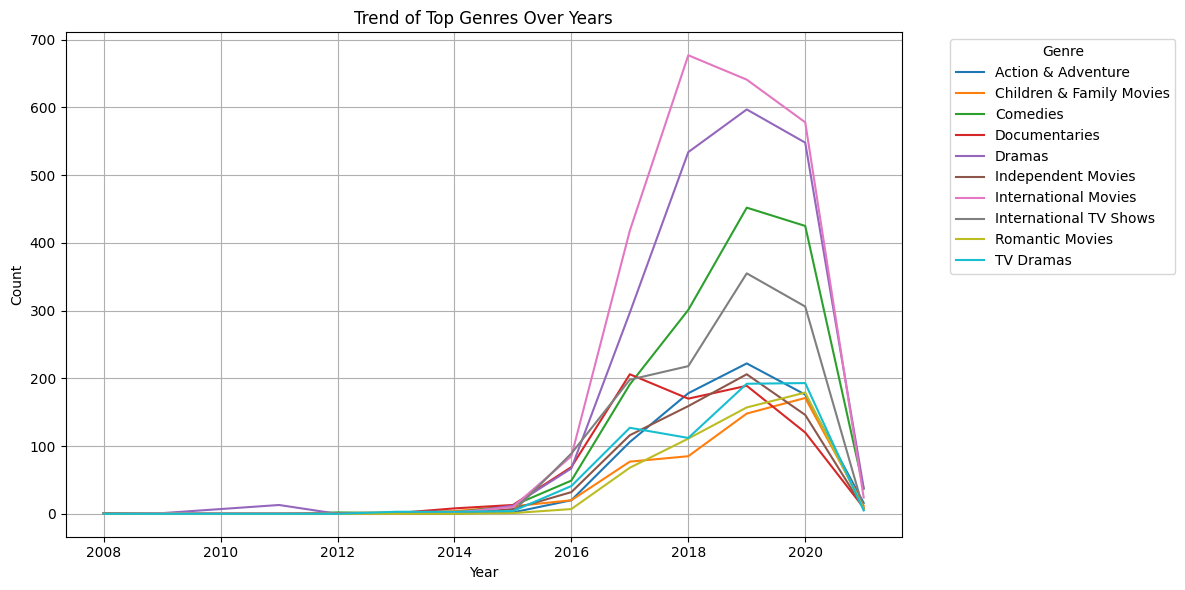

In [5]:
# 4) Genres analysis - explode genres and count
genres_exploded = df[['Year','Genres']].explode('Genres')
genres_exploded['Genres'] = genres_exploded['Genres'].str.strip().replace('', np.nan)
top_genres = genres_exploded['Genres'].value_counts().nlargest(10)
print('Top 10 genres overall:')
display(top_genres)

# Trend of top genres over years
top_list = top_genres.index.tolist()
trend = genres_exploded[genres_exploded['Genres'].isin(top_list)].groupby(['Year','Genres']).size().unstack(fill_value=0).sort_index()

plt.figure(figsize=(12,6))
trend.plot(ax=plt.gca())
plt.title('Trend of Top Genres Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5) Country-wise contributions
Show top contributing countries and a bar plot.

Top 15 countries by content count:


,count
Country,
United States,3298
India,990
United Kingdom,723
Canada,412
France,349
Japan,287
Spain,215
South Korea,212
Germany,199


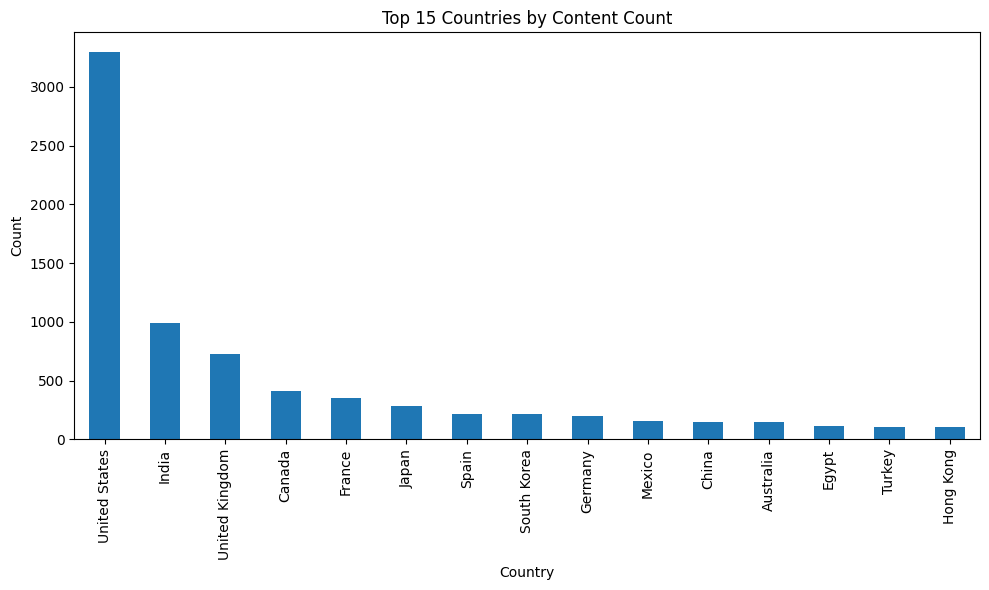

In [6]:
# 5) Country-wise contributions
country_series = df['Country'].dropna().str.split(',', expand=False).explode().str.strip()
top_countries = country_series.value_counts().nlargest(15)
print('Top 15 countries by content count:')
display(top_countries)

# Plot top countries
plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', ax=plt.gca())
plt.title('Top 15 Countries by Content Count')
plt.xlabel('Country')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 6) Ratings and duration
- Ratings distribution
- Duration histogram (minutes for movies)

,count
Rating,
TV-MA,2865
TV-14,1931
TV-PG,806
R,665
PG-13,386
TV-Y,280
TV-Y7,271
PG,247
TV-G,194


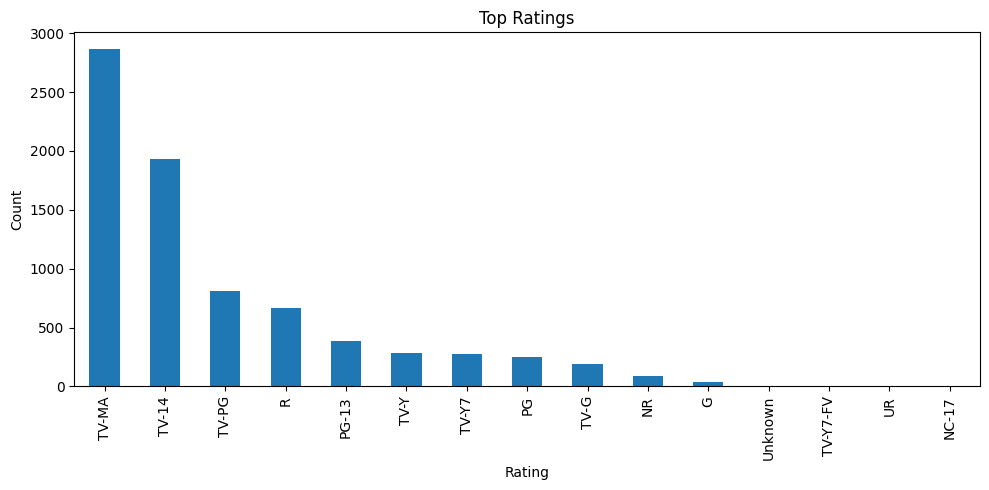

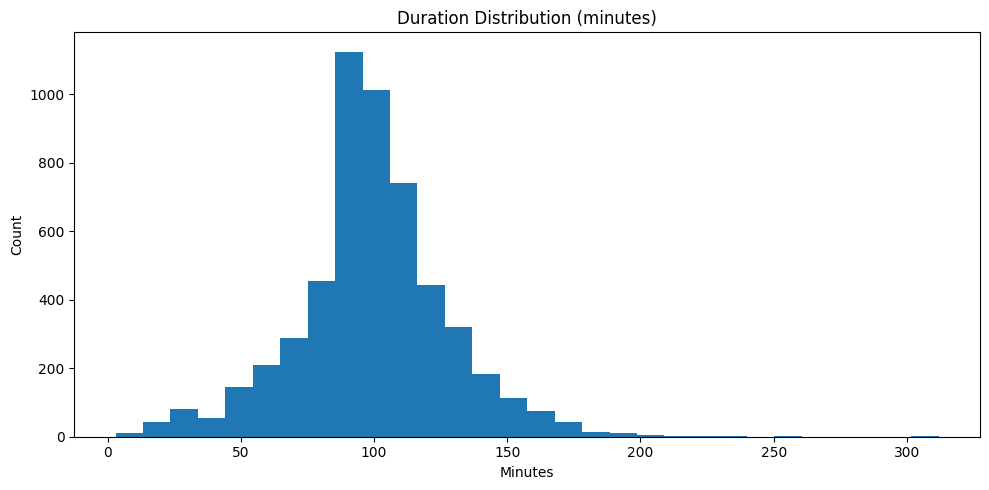

In [7]:
# 6) Ratings distribution
rating_counts = df['Rating'].fillna('Unknown').value_counts().nlargest(20)
display(rating_counts)

plt.figure(figsize=(10,5))
rating_counts.plot(kind='bar', ax=plt.gca())
plt.title('Top Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Duration histogram (only positive numeric minutes)
dur_minutes = df[df['Duration_numeric']>0]['Duration_numeric'].dropna()
plt.figure(figsize=(10,5))
plt.hist(dur_minutes, bins=30)
plt.title('Duration Distribution (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 7) Top directors & sample titles

In [8]:
# 7) Top directors & sample titles
top_directors = df['Director'].dropna().value_counts().nlargest(10)
display(top_directors)

if not top_directors.empty:
    top_dir = top_directors.index[0]
    print(f"Sample titles from top director: {top_dir}")
    display(df[df['Director']==top_dir][['Title','Year','Category']].head())

,count
Director,
"Raúl Campos, Jan Suter",18
Marcus Raboy,16
Jay Karas,14
Cathy Garcia-Molina,13
Martin Scorsese,12
Youssef Chahine,12
Jay Chapman,12
Steven Spielberg,10
David Dhawan,9


Sample titles from top director: Raúl Campos, Jan Suter


,Title,Year,Category
370,Alan Saldaña: Mi vida de pobre,2017.0,Movie
568,Arango y Sanint: Ríase el show,2018.0,Movie
1220,Carlos Ballarta: Furia Ñera,2018.0,Movie
1443,Coco y Raulito: Carrusel de ternura,2018.0,Movie
1602,Daniel Sosa: Sosafado,2017.0,Movie


## 8) Save cleaned CSV (optional)
If you'd like, run the cell below to save a cleaned copy of the dataset to the notebook folder.

In [11]:
# Save cleaned dataset
clean_path ='/content/Netflix Dataset.csv '
df.to_csv(clean_path, index=False)
print('Saved cleaned dataset to', clean_path)

Saved cleaned dataset to /content/Netflix Dataset.csv 


## Conclusion & next steps
- Notebook provides EDA aligned to the project objectives.
- Next steps: more advanced analysis (topic modelling on descriptions, recommendation system prototypes, clustering by genres/country, time series forecasting of releases).

---

*Notebook generated automatically.*